# Experimenting with patches

I want to check if there's a simple way to translate a 3D image into patches so that I can give the patches (or some selection of patches) to a function to perturb

In [1]:
import numpy as np
from convert_nifti import Nifti2Numpy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
img = "/Users/caeochoa/Documents/GUH20/VChecklist/nn-UNet/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BraTS2021/BraTS2021_00495/BraTS2021_00495_flair.nii.gz"
flair = Nifti2Numpy(img)[0]

In [3]:
def show_slices_multiple(list_of_slices):
    fig, axes = plt.subplots(1, len(list_of_slices[0]), figsize=(10,5))
    assert len(list_of_slices) <= 3, "Too many slices"
    cmap = ["gray", "plasma", "viridis"]
    for j, slices in enumerate(list_of_slices):
        for i, slice in enumerate(slices):
            if j == 0:
                axes[i].imshow(slice.T, cmap=cmap[j], origin="lower")#, alpha=alpha)
                axes[i].axis("off")
            else:
                alpha = slice.T > 0
                alpha = alpha.astype(np.uint8)
                im = axes[i].imshow(slice.T, cmap=cmap[j], origin="lower", alpha=alpha)
                values = np.unique(slice)[1:]
                colors = [ im.cmap(im.norm(value)) for value in values]
                labels = {"0": "Everything else", "1": "NCR", "2": "ED", "4": "ET", "3":"ET"}
                patches = [ mpatches.Patch(color=colors[i], label=labels[str(values[i])] ) for i in range(len(values)) ]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
                
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()
    
def central_slices(img:np.ndarray):
    assert len(img.shape) == 3, "Image should have 3 dimensions"
    s = img.shape
    return [img[s[0]//2, :, :], img[:, s[1]//2, :], img[:, :, s[2]//2]]

In [4]:
def pad_img(img:np.ndarray, patch_shape:int, axis):
    #assert len(img.shape) == len(patch_shape), f"Patch shape {patch_shape}, doesn't fit number of dimensions ({len(img.shape)})"
    mod = img.shape[axis]%patch_shape
    shape = list(img.shape)
    shape[axis] = (patch_shape - mod)//2
    pad_img = np.append(np.zeros(shape), img, axis)
    #assert np.all(pad_img[shape[0]:, :, :] == img), f"{axis}: {pad_img[shape[0]:, :, :].shape}, {img.shape}"
    shape[axis] = (patch_shape - mod)//2 + (patch_shape - mod)%2
    pad_img = np.append(pad_img, np.zeros(shape), axis)
    return pad_img

In [5]:
def split_into_patches(img:np.ndarray, patch_shape:tuple):
    assert len(img.shape) == len(patch_shape), f"Patch shape {patch_shape}, doesn't fit number of dimensions ({len(img.shape)})"
    patchnum = []
    padimg = img.copy()
    for dim in range(len(img.shape)):
        padimg = pad_img(padimg, patch_shape[dim], dim)
        assert padimg.shape[dim] % patch_shape[dim] == 0, f"{padimg.shape},{patch_shape},{dim}"
        patchnum.append(padimg.shape[dim]//patch_shape[dim])
    patches = np.zeros(tuple(patchnum) + patch_shape)
    
    for i in range(patchnum[0]):
        for j in range(patchnum[1]):
            for k in range(patchnum[2]):
                patches[i,j,k] = padimg[i*patch_shape[0]:(i+1)*patch_shape[0], j*patch_shape[1]:(j+1)*patch_shape[1], k*patch_shape[2]:(k+1)*patch_shape[2]]

    return patches

In [6]:
flair.shape

(240, 240, 155)

In [7]:
patches = split_into_patches(flair, (50,50,50))

In [8]:
patches.shape

(5, 5, 4, 50, 50, 50)

In [9]:
def paste_patches(patches:np.ndarray):
    dims = len(patches.shape)//2
    img = np.zeros([patches.shape[i+dims]*patches.shape[i] for i in range(dims)])

    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            for k in range(patches.shape[2]):
                img[i*patches.shape[3]:(i+1)*patches.shape[3], j*patches.shape[4]:(j+1)*patches.shape[4], k*patches.shape[5]:(k+1)*patches.shape[5]] = patches[i,j,k]
    
    return img

In [10]:
img = paste_patches(patches)

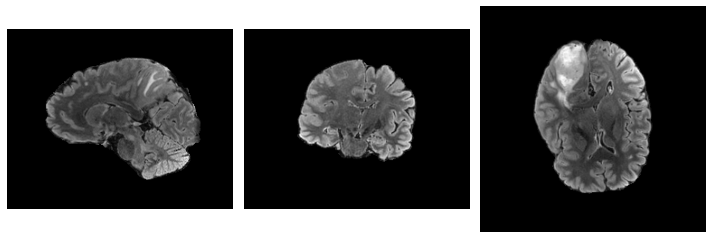

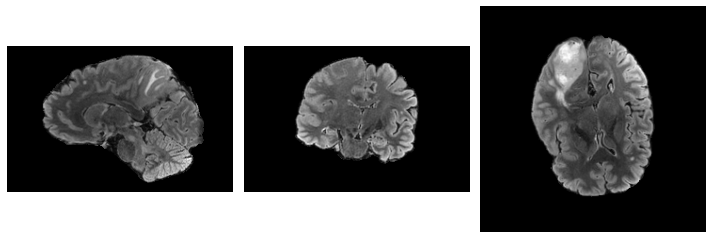

In [11]:
show_slices_multiple([central_slices(img)])
show_slices_multiple([central_slices(flair)])

In [12]:
def pad_selection(patches:np.ndarray, selection:np.ndarray, axis, value=0):
    #assert len(img.shape) == len(patch_shape), f"Patch shape {patch_shape}, doesn't fit number of dimensions ({len(img.shape)})"
    rem = patches.shape[axis]-selection.shape[axis]
    shape = list(selection.shape)
    shape[axis] = rem//2
    selection = np.append(np.full(shape, value), selection, axis)
    shape[axis] = rem//2 + rem%2
    selection = np.append(selection, np.full(shape, value), axis)
    return selection.astype(np.bool8)

In [13]:
def CentralPatchSelection(patches:np.ndarray, probability:float):
    selection = np.random.rand(patches.shape[0]//2,patches.shape[1]//2,patches.shape[2]//2)#, patches.shape[3], patches.shape[4], patches.shape[5])
    selection = selection <= probability
    for axis in range(len(selection.shape)):
        selection = pad_selection(patches, selection, axis)
    #selection = np.expand_dims(selection, 3)
    #selection = np.expand_dims(selection, 3)
    #selection = np.expand_dims(selection, 3)


    return selection.astype(np.bool8)

In [14]:
select = CentralPatchSelection(patches, 1)

rot = patches.copy()

for i in range(select.shape[0]):
    for j in range(select.shape[1]):
        for k in range(select.shape[2]):
            if select[i,j,k]:
                rot[i,j,k] = np.rot90(rot[i,j,k], 1)



In [49]:
def apply_perturbation(patches, select_rule, perturbation, select_prob=1, pert_k=1):
    if type(select_rule) == np.ndarray:
        select = np.random.rand(select_rule[select_rule==True].shape[0])
        select = select <= select_prob
        select_rule[select_rule == True] = select
        select = select_rule
    else:
        select = select_rule(patches, select_prob)

    rot = patches.copy()

    for i in range(select.shape[0]):
        for j in range(select.shape[1]):
            for k in range(select.shape[2]):
                if select[i,j,k]:
                    rot[i,j,k] = perturbation(rot[i,j,k], pert_k)

    return rot



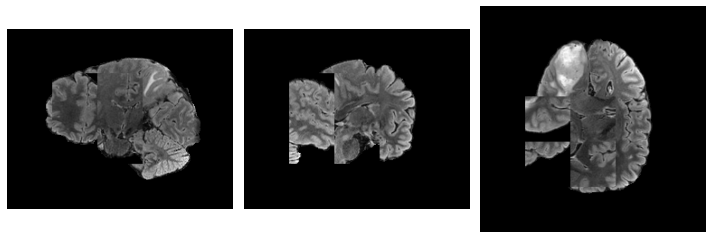

In [16]:
rot = paste_patches(rot)
show_slices_multiple([central_slices(rot)])



In [17]:
from scipy.ndimage import zoom

def blurr(img, k):
    return zoom(zoom(img, (k, k, k)), (1/k,1/k,1/k))

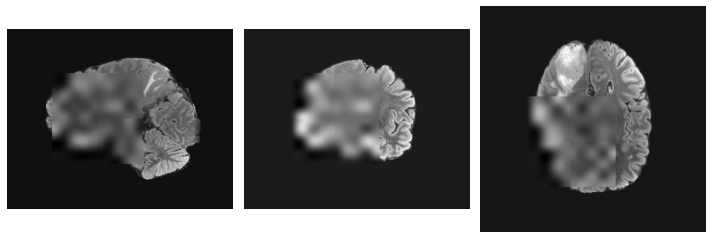

In [18]:
select = CentralPatchSelection(patches, 1)

rot = patches.copy()

for i in range(select.shape[0]):
    for j in range(select.shape[1]):
        for k in range(select.shape[2]):
            if select[i,j,k]:
                rot[i,j,k] = blurr(rot[i,j,k], 0.1)

rot = paste_patches(rot)
show_slices_multiple([central_slices(rot)])


In [19]:
def intensity(img, k):
    amount = k/100*255
    return img+amount

In [20]:
def RandomPatches(patches, probability):
    select = np.random.rand(patches.shape[0], patches.shape[1], patches.shape[2])
    select = select <= probability
    return select.astype(np.bool8)

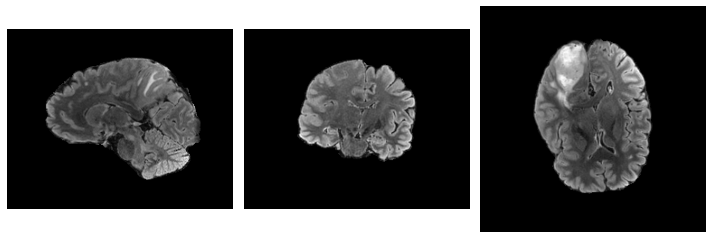

In [21]:
img = apply_perturbation(patches, RandomPatches, intensity, 1, 500000000)
img = paste_patches(img)
show_slices_multiple([central_slices(img)])

In [22]:
img = central_slices(img)[2]

In [23]:
def show_slices_single(list_of_slices):
    fig, axes = plt.subplots(1, len(list_of_slices[0]), figsize=(10,5))
    assert len(list_of_slices) <= 3, "Too many slices"
    cmap = ["gray", "plasma", "viridis"]
    for j, slices in enumerate(list_of_slices):
        for i, slice in enumerate(slices):
            if j == 0:
                axes.imshow(slice.T, cmap=cmap[j], origin="lower")#, alpha=alpha)
                axes.axis("off")
            else:
                alpha = slice.T > 0
                alpha = alpha.astype(np.uint8)
                im = axes.imshow(slice.T, cmap=cmap[j], origin="lower", alpha=alpha)
                values = np.unique(slice)[1:]
                colors = [ im.cmap(im.norm(value)) for value in values]
                labels = {"0": "Everything else", "1": "NCR", "2": "ED", "4": "ET", "3":"ET"}
                patches = [ mpatches.Patch(color=colors[i], label=labels[str(values[i])] ) for i in range(len(values)) ]
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
                
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.tight_layout()

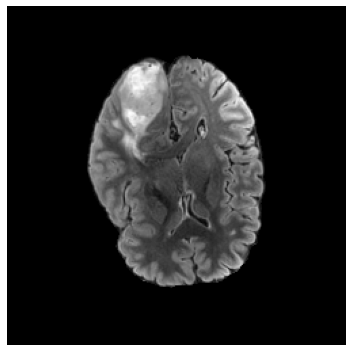

In [24]:
img[img != 0] += 1000
show_slices_single([[img]])

In [25]:
img = paste_patches(patches)


In [26]:

img[img != 0]

array([ 59.,  94.,  78., ...,  89., 135., 112.])

In [27]:
# normalize

max = img[img!=0].max()
img /= max

In [28]:
img[img!=0]+=0.3
img[img>1]=1

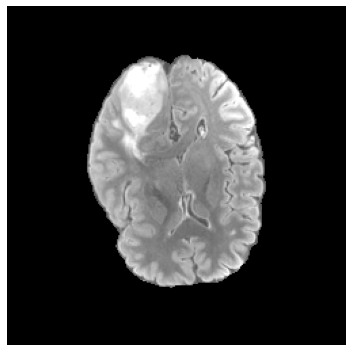

In [29]:
show_slices_single([[central_slices(img)[2]]])

In [30]:
def intensity(img:np.ndarray, k):
    
    if np.any(img != 0):
        # normalize
        max = img[img!=0].max()
        img /= max

        img[img!=0]+=k/100
        img[img>1]=1

    return img
    

In [31]:
def intensity(img:np.ndarray, k):
    
    if np.any(img != 0):
        max = img[img!=0].max()

        img[img!=0]+=k/100*max
        img[img>max]=max

    return img
    

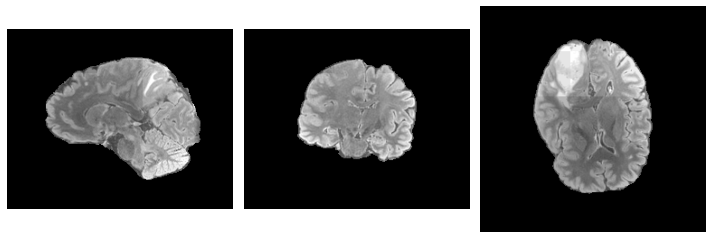

In [32]:
img = apply_perturbation(patches, RandomPatches, intensity, 1, 30)
img = paste_patches(img)
show_slices_multiple([central_slices(img)])

In [33]:
def OuterPatchSelection(patches:np.ndarray, probability:float):
    selection = np.random.rand(patches.shape[0],patches.shape[1],patches.shape[2])
    selection = selection <= probability
    centre = CentralPatchSelection(patches, 1) 
    selection[centre] = False

    return selection

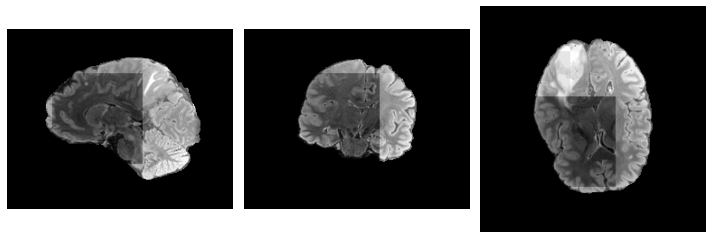

In [34]:
img = apply_perturbation(patches, OuterPatchSelection, intensity, 0.9, 30)
img = paste_patches(img)
show_slices_multiple([central_slices(img)])

# Manual patch selection

In [35]:
flair.shape
# tumour is in [70:110,128:205,100:132]

(240, 240, 155)

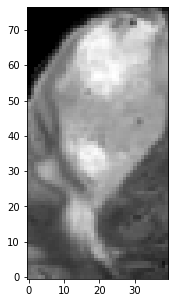

In [36]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.imshow(flair[70:110, 128:205, 155//2].T, cmap="gray", origin="lower")

In [93]:
select = np.zeros(flair.shape)
select[70:110,128:205,100:132] = 1 
select = select.astype(np.bool8)

In [94]:
select = split_into_patches(select, (50,50,50)).astype(np.bool8)

In [95]:
def patch_selection_intersection(select:np.ndarray):
    new_select = np.zeros((select.shape[0],select.shape[1],select.shape[2]), np.bool8)
    for i in range(select.shape[0]):
        for j in range(select.shape[1]):
            for k in range(select.shape[2]):
                if np.any(select[i,j,k]):
                    new_select[i,j,k] = True

    return new_select

In [96]:
select = patch_selection_intersection(select)

In [97]:
def occlude(img:np.ndarray, *args):
    return np.zeros(img.shape)

In [98]:
img = apply_perturbation(patches, select, occlude, select_prob=1, pert_k=10)

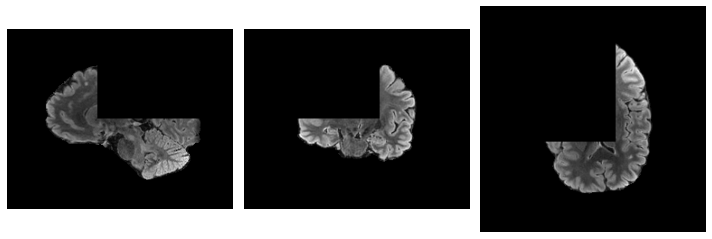

In [99]:
img = paste_patches(img)
show_slices_multiple([central_slices(img)])